<a id="top"></a>
 <font size="5">Propositions</font>
> 

> * Prepared by Alfredo López
> * alfredo.lopez@scch.at
> 
<hr>
<hr>

**OBS**: The purpose of the following notebook is to perform a sanity check of the correctness of propostions at the paper.  

Not valid as a proof, of course.

Not valid as unit testing, either. 

In [1]:
import numpy as np

class Sinusoidal():

    def __init__(self, alpha, beta, omega, phi, real=False):
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.phi = phi
        self.real = real

    def __call__(self, t):
        y = self.alpha*np.exp(-self.beta*t + 1j*self.omega*t + 1j*self.phi)
        if self.real:
            return np.real(y)
        else:
            return y

class AR2():

    def __init__(self, phi1, phi2, y1, y2):
        self.phi1 = phi1
        self.phi2 = phi2
        self.y1 = y1
        self.y2 = y2

    def __call__(self, n):
        y = [self.y1, self.y2]
        for i in range(2, n):
            y.append(self.phi1*y[i-1] + self.phi2*y[i-2])
        return y
    

# Proposition 1

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

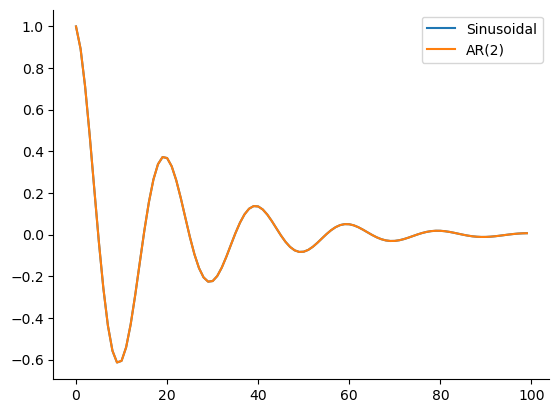

In [3]:
# parameters for the sinusoidal function
alpha = 1
beta = 0.05
omega = np.pi/10
phi = 0.04

# Sinusoidal model
f = Sinusoidal(alpha=alpha, beta=beta, omega=omega, phi=phi, real=True)

# AR(2) model
y1 = alpha*np.cos(phi) # initial conditions
y2 = alpha*np.exp(-beta)*np.cos(omega + phi) # initial conditions
phi1 = 2*np.exp(-beta)*np.cos(omega) # autoregressive parameter
phi2 = -np.exp(-2*beta) # autoregressive parameter
ar2 = AR2(phi1=phi1, phi2=phi2, y1=y1, y2=y2)

# plot
n = 100
t = np.arange(n)
plt.plot(t, np.real(f(t)), label='Sinusoidal')
plt.plot(t, np.real(ar2(n)), label='AR(2)')
plt.legend()
sns.despine()

# Proposition 2

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

alpha: 1.0462967275611939
beta: 0.020410997260127583
omega: 0.5205864859277355
phi: -0.2985913746359427


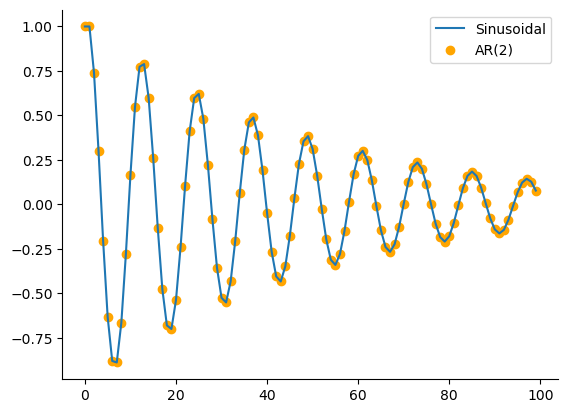

In [5]:
y1 = 1.0
y2 = 1.0
phi1 = 1.7
phi2 = -0.96

# Generate AR(2) model
ar2 = AR2(phi1=phi1, phi2=phi2, y1=y1, y2=y2)

# Compute parameters of the sinusoidal model
beta = -0.5*np.log(-phi2)
omega = np.arccos(0.5*phi1*np.exp(beta))
tgphi = (y1*np.exp(-beta)*np.cos(omega) - y2)/(y1*np.exp(-beta)*np.sin(omega))
phi = np.arctan(tgphi)
alpha = y1*np.sqrt(1 + tgphi**2)

print('alpha:', alpha)
print('beta:', beta)
print('omega:', omega)
print('phi:', phi)

f = Sinusoidal(alpha=alpha, beta=beta, omega=omega, phi=phi, real=True)

n = 100
t = np.arange(n)
plt.plot(t, np.real(f(t)), label='Sinusoidal')
plt.scatter(t, ar2(n), color='orange', label='AR(2)')
plt.legend()
sns.despine()

# Proposition 3

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pitsa

y1=1.00, y2=0.93, varphi1=1.86, varphi2=-0.96


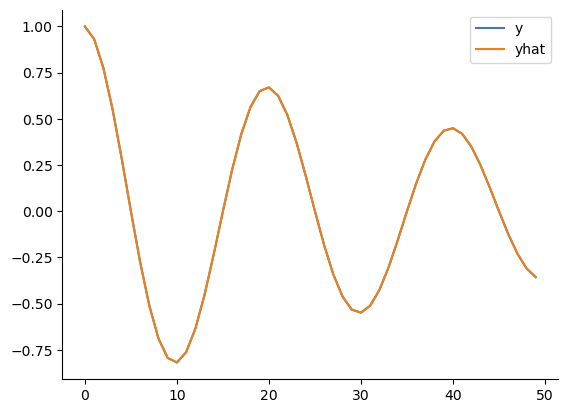

In [7]:
# parameters for the sinusoidal function
alpha = 1
beta = 0.02
omega = np.pi/10
phi = 0

# AR(2) model
y1 = alpha*np.cos(phi) # initial conditions
y2 = alpha*np.exp(-beta)*np.cos(omega + phi) # initial conditions
varphi1 = 2*np.exp(-beta)*np.cos(omega) # autoregressive parameter
varphi2 = -np.exp(-2*beta) # autoregressive parameter
print('y1={:.2f}, y2={:.2f}, varphi1={:.2f}, varphi2={:.2f}'.format(y1, y2, varphi1, varphi2))
ar2 = AR2(phi1=varphi1, phi2=varphi2, y1=y1, y2=y2)

n = 40
m = 10
t = np.arange(n+m)

#yhp = [float(pitsa.xai.importance.arhp(tt, phi=[varphi1, varphi2], ics=[y1, y2], precision=50)) for tt in t]
y = ar2(n+m)
yhat = y[:n] + [float(pitsa.xai.importance.ar(tt, phi=[varphi1, varphi2], ics=[y[n], y[n+1]])) for tt in np.arange(m)]

yfore = ar2(n+m)
plt.plot(t, y, label='y')
plt.plot(t, yhat, label='yhat')
#plt.plot(t, yhp, label='yhp')
plt.legend()
sns.despine()

assert np.allclose(yhat, y, atol=0.01), 'Error in the formula'

# Propoisition 4

In [8]:
# See the assertions at Propostion 5.

# Proposition 5

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pitsa

## i. polynomial

,intercept,slope,quadratic
0,1.0,2.0,0.5


,intercept,slope,quadratic
60,1.0,120.0,1800.0


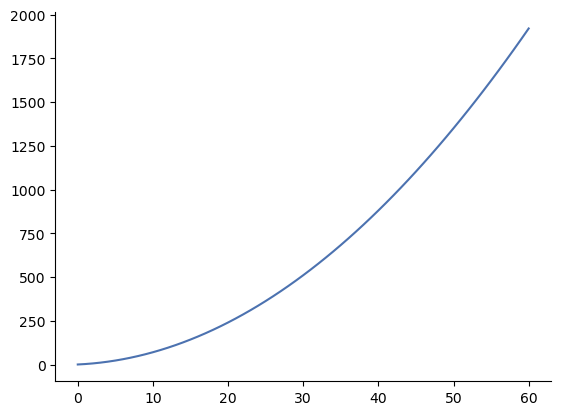

In [10]:
n = 61
t = np.arange(n)

theta = {'intercept': 1, 'slope': 2, 'quadratic': 0.5}
y = theta['intercept'] + theta['slope']*t + theta['quadratic']*t**2

plt.plot(t, y)
sns.despine()

k = n-1
explanation, importance = pitsa.xai.importance.integrated_gradient(t=t[k:k+1], theta_bf=theta, model='Sklearn-Model')

display(explanation)
display(importance)
assert np.allclose(importance.sum(axis=1), y[k], atol=1e-10)

## ii. sinusoidal

,amplitude,decay,frequency,phase
0,-1.0,-0.01,0.15708,-0.1


,amplitude,decay,frequency,phase
60,-0.016476,0.005159,2.126014,-0.022558


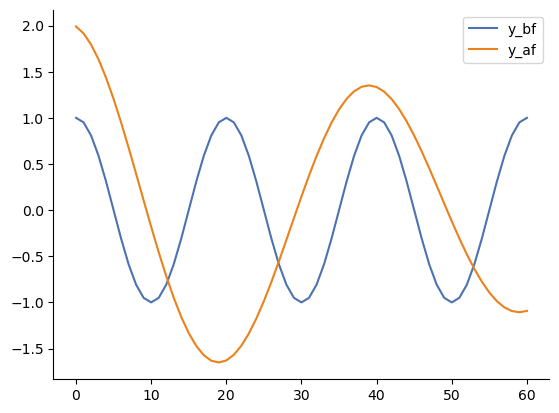

In [11]:
theta_bf = {'amplitude':1, 'decay':0, 'frequency':np.pi/10, 'phase':0}
theta_af = {'amplitude':2, 'decay':0.01, 'frequency':np.pi/20, 'phase':0.1}

y_bf = theta_bf['amplitude']*np.exp(-theta_bf['decay']*t)*np.cos(theta_bf['frequency']*t + theta_bf['phase'])
y_af = theta_af['amplitude']*np.exp(-theta_af['decay']*t)*np.cos(theta_af['frequency']*t + theta_af['phase'])

plt.plot(t, y_bf, label='y_bf')
plt.plot(t, y_af, label='y_af')
plt.legend()
sns.despine()

k = n -1
explanation, importance = pitsa.xai.importance.integrated_gradient(t=t[k:k+1], theta_bf=theta_bf, theta_af=theta_af, model='KernelBasisFunction')

display(explanation)
display(importance)
assert np.allclose(importance.sum(axis=1), y_bf[k] - y_af[k], atol=1e-10)

## iii. AR(2)

In [12]:
# import importlib

# import pitsa_lite.xai.importance as importance
# importlib.reload(importance)

In [13]:
alpha = 1
beta = 0.0
omega = np.pi/10
phi = 0.0
y1 = alpha*np.cos(phi) # initial conditions
y2 = alpha*np.exp(-beta)*np.cos(omega + phi) # initial conditions
phi1_bf = 2*np.exp(-beta)*np.cos(omega) # autoregressive parameter
phi2_bf = -np.exp(-2*beta) # autoregressive parameter
theta_bf = {'ar.L1': phi1_bf, 'ar.L2': phi2_bf}

alpha = 1
beta = 0.02
omega = np.pi/10
phi = 0.0
phi1_af = 2*np.exp(-beta)*np.cos(omega) # autoregressive parameter
phi2_af = -np.exp(-2*beta) # autoregressive parameter
theta_af = {'ar.L1': phi1_af, 'ar.L2': phi2_af}

n = 100
t = np.arange(n)
ar2_bf = AR2(phi1=phi1_bf, phi2=phi2_bf, y1=y1, y2=y2)
ar2_af = AR2(phi1=phi1_af, phi2=phi2_af, y1=y1, y2=y2)
y_bf = ar2_bf(n)
y_af = ar2_af(n)

t = 50
explanation, importance = pitsa.xai.importance.integrated_gradient(t=t, 
                                                                   theta_bf=theta_bf, 
                                                                   theta_af=theta_af, 
                                                                   model='RobustAutoRegressiveRegression', 
                                                                   ics=[y1, y2], 
                                                                   hp=True)

display(explanation)
display(importance)

assert np.allclose(np.sum(importance.values), y_bf[t] - y_af[t], atol=0.01), 'Importance sum = {:.2f} not equal to y_bf - y_af = {:.2f}'.format(np.sum(importance.values), y_bf[t] - y_af[t])

Computing IG for AR model with high precision
Precision: 50


,ar.L1,ar.L2
0,0.037664,-0.039211


,ar.L1,ar.L2
50,0.040775,-0.672895


# Proposition 6

In [14]:
# See 1_2_syn_data.ipynb